In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras

%load_ext tensorboard

import numpy as np
import os

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#### Some of the problems you could run into when training a deep DNN: 
- You may be faced with the tricky **vanishing gradients problem** or the related **exploding gradients problem**. 
    - **This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training.** 
    - Both of these problems make lower layers very hard to train.
- You might not have enough training data for such a large network, or it might be too costly to label.
- Training may be extremely slow.
- A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

## The Vanishing/Exploding Gradients Problems
- The backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient along the way. 
    - Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.
- **Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers.** 
    - As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution.
    - **We call this the vanishing gradients problem.**
- In some cases, the opposite can happen: **the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges.**
    - This is the **exploding gradients problem**, which surfaces in recurrent neural networks. 
- More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.
***
- This unfortunate behavior was empirically observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000s. 
- It wasn’t clear what caused the gradients to be so unstable when training a DNN, but some light was shed in a 2010 paper by Xavier Glorot and Yoshua Bengio. 
    - The authors found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1).
    - In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs.
    - Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. 
    - This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

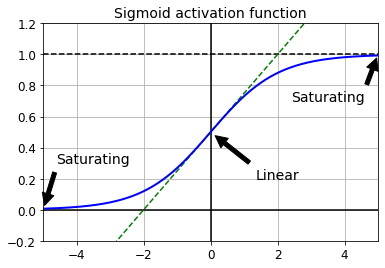

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

- Looking at the logistic activation function above, you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. 
- Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

## Glorot and He Initialization
- In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. 
    - They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients.
    - We don’t want the signal to die out, nor do we want it to explode and saturate. 
    - For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction.
- It is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the fan-in and fan-out of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described in Equation 11-1, where. <img src="1.png">
    - This initialization strategy is called **Xavier initialization** or **Glorot initialization**, after the paper’s first author.
<img src="11-1.png">

- If you replace fan with $fan_in$ in Equation 11-1, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it LeCun initialization. 
- Genevieve Orr and Klaus-Robert Müller even recommended it in their 1998 book Neural Networks: Tricks of the Trade (Springer).
- LeCun initialization is equivalent to Glorot initialization when $fan_in$ = $fan_out$ . 
    - It took over a decade for researchers to realize how important this trick is. Using Glorot initialization can speed up training considerably, and it is one of the tricks that led to the success of Deep Learning.
- Some papers have provided similar strategies for different activation functions. 
    - These strategies differ only by the scale of the variance and whether they use $fan_avg$ or $fan_in$ , as shown in Table 11-1.
- **The initialization strategy for the ReLU activation function** (and its variants, including the ELU activation described shortly) is sometimes called **He initialization**, after the paper’s first author.
<img src="t1.png">

- By default, Keras uses **Glorot initialization** with a uniform distribution.
    - When creating a layer, you can change this to He initialization by setting kernel_initializer="he_uniform" or kernel_initializer="he_normal"

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

If you want He initialization with a uniform distribution but based on $fan_avg$ rather than $fan_in$ , you can use the VarianceScaling initializer like this:

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions
- One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function. Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice.
- But it turns out that other activation functions behave much better in deep neural networks—in particular, the **ReLU** activation function, mostly because it does not saturate for positive values (and because it is fast to compute).
- Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs: during training, some neurons effectively “die,” meaning they stop outputting anything other than 0. 
    - In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate.
    - A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. 
    - When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.
    - To solve this problem, you may want to use a variant of the ReLU function, such as the **leaky ReLU**.
    
### Leaky ReLU
- The hyperparameter α(alpha) defines how much the function “leaks”: it is the slope of the function for z < 0 and is typically set to 0.01. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up.

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

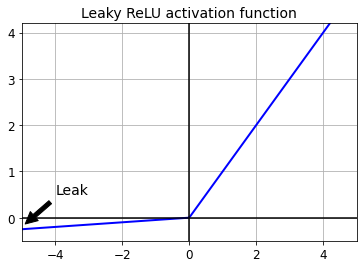

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(300, kernel_initializer="he_normal"), 
    keras.layers.LeakyReLU(), 
    keras.layers.Dense(100, kernel_initializer="he_normal"), 
    keras.layers.LeakyReLU(), 
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3), 
              metrics=["accuracy"])

In [13]:
history = model.fit(X_train, y_train, epochs=10, 
                   validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.6314 - accuracy: 0.5054 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8416 - accuracy: 0.7247 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7053 - accuracy: 0.7637 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6325 - accuracy: 0.7908 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5992 - accuracy: 0.8021 - val_loss: 0.5582 - val_accuracy: 0.8198
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5624 - accuracy: 0.8142 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5379 - accuracy: 0.8217 - val_loss: 0.5156 - val_accuracy:

## PReLU
- The paper evaluated the parametric leaky ReLU (PReLU), where α is authorized to be **learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter).** 
- PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.
Now let's try PReLU:

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(300, kernel_initializer="he_normal"), 
    keras.layers.PReLU(), 
    keras.layers.Dense(100, kernel_initializer="he_normal"), 
    keras.layers.PReLU(), 
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [16]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.6969 - accuracy: 0.4974 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8706 - accuracy: 0.7247 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7211 - accuracy: 0.7620 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6448 - accuracy: 0.7881 - val_loss: 0.6004 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6078 - accuracy: 0.8003 - val_loss: 0.5656 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5693 - accuracy: 0.8119 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5428 - accuracy: 0.8194 - val_loss: 0.5196 - val_accuracy:

## ELU
- A 2015 paper by Djork-Arné Clevert et al. proposed a new activation function called the **exponential linear unit (ELU)** that outperformed all the ReLU variants in the authors’ experiments: training time was reduced, and the neural network performed better on the test set.
<img src="11-2.png">
- The ELU activation function looks a lot like the ReLU function, with a few major differences:
    - **It takes on negative values when z < 0, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem.** 
        - The hyperparameter α defines the value that the ELU function approaches when z is a large negative number. 
        - It is usually set to 1, but you can tweak it like any other hyperparameter.
    - It has a nonzero gradient for z < 0, which avoids the dead neurons problem.
    - **If α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent since it does not bounce as much to the left and right of z = 0.**

In [17]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

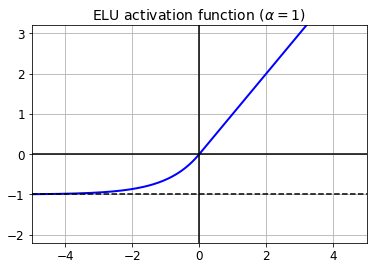

In [18]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [19]:
keras.layers.Dense(10, activation="elu")

## SELU
- This activation function was proposed in a great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. 
- **During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem.** 
    - As a result, this activation function outperforms the other activation functions very significantly for such neural nets. 
    - **The input features must be standardized (mean 0 and standard deviation 1).**
    - **Every hidden layer’s weights must be initialized with LeCun normal initialization.** 
        - In Keras, this means setting kernel_initializer="lecun_normal".
    - **The network’s architecture must be Sequential.** 
    - Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.
    - Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). 
    - However, in practice it works quite well with sequential CNNs. 
    - If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [20]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [21]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

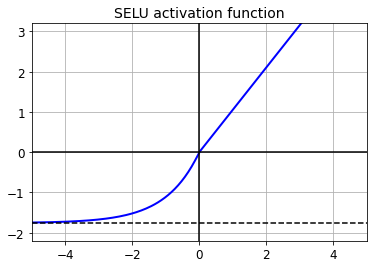

In [22]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [23]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [24]:
keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))

for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(lr=1e-3), 
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [28]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [29]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 50s 27ms/step - loss: 1.3254 - accuracy: 0.4924 - val_loss: 0.7693 - val_accuracy: 0.7192
Epoch 2/5
1719/1719 [==============================] - 47s 27ms/step - loss: 0.7608 - accuracy: 0.7294 - val_loss: 0.6361 - val_accuracy: 0.7780
Epoch 3/5
1719/1719 [==============================] - 45s 26ms/step - loss: 0.6213 - accuracy: 0.7806 - val_loss: 0.5794 - val_accuracy: 0.7962
Epoch 4/5
1719/1719 [==============================] - 42s 24ms/step - loss: 0.5377 - accuracy: 0.8141 - val_loss: 0.4850 - val_accuracy: 0.8306
Epoch 5/5
1719/1719 [==============================] - 43s 25ms/step - loss: 0.4936 - accuracy: 0.8289 - val_loss: 0.4789 - val_accuracy: 0.8358


Now look at what happens if we try to use the ReLU activation function instead:

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [33]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 48s 26ms/step - loss: 2.0999 - accuracy: 0.1760 - val_loss: 1.7955 - val_accuracy: 0.2882
Epoch 2/5
1719/1719 [==============================] - 43s 25ms/step - loss: 1.3662 - accuracy: 0.4005 - val_loss: 0.9627 - val_accuracy: 0.5952
Epoch 3/5
1719/1719 [==============================] - 43s 25ms/step - loss: 0.9966 - accuracy: 0.5824 - val_loss: 0.9120 - val_accuracy: 0.6410
Epoch 4/5
1719/1719 [==============================] - 42s 24ms/step - loss: 0.9921 - accuracy: 0.5944 - val_loss: 0.7455 - val_accuracy: 0.7198
Epoch 5/5
1719/1719 [==============================] - 43s 25ms/step - loss: 0.7753 - accuracy: 0.6996 - val_loss: 0.8021 - val_accuracy: 0.6832


Not great at all, we suffered from the vanishing/exploding gradients problem.

### TIP
So, which activation function should you use for the hidden layers of your deep neural networks? 
- Although your mileage will vary, in general SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic.
- If the network’s architecture prevents it from self-normalizing, then ELU may perform better than SELU (since SELU is not smooth at z = 0).
- If you care a lot about runtime latency, then you may prefer leaky ReLU. 
    - If you don’t want to tweak yet another hyperparameter, you may use the default α values used by Keras (e.g., 0.3 for leaky ReLU).
- If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, such as RReLU if your network is overfitting or PReLU if you have a huge training set.
- That said, because
- ReLU is the most used activation function (by far), many libraries and hardware accelerators provide ReLU-specific optimizations; therefore, if speed is your priority, ReLU might still be the best choice.

## Batch Normalization
- Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.
- In a 2015 paper, Sergey Ioffe and Christian Szegedy proposed a technique called **Batch Normalization(BN)** that addresses these problems.
- The technique consists of **adding an operation in the model just before or after the activation function of each hidden layer.**
    - This operation simply zerocenters and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting.
    - In other words, **the operation lets the model learn the optimal scale and mean of each of the layer’s inputs.**
    - In many cases, **if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler); the BN layer will do it for you** (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).
- In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. 
    - It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”). 

In [34]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"), 
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

- As you can see, each BN layer adds four parameters per input: γ, β, μ, and σ (for example, the first BN layer adds 3,136 parameters, which is 4 × 784).
- The last two parameters, μ and σ, are the moving averages; they are not affected by backpropagation, so Keras calls them “non-trainable” (if you count the total number of BN parameters, 3,136 + 1,200 + 400, and divide by 2, you get 2,368, which is the total number of non-trainable parameters in this model).

- Batch Normalization acts like a regularizer, reducing the need for other regularization techniques.
- Batch Normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data). 
- Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. 
- Fortunately, it’s often possible to fuse the BN layer with the previous layer, after training, thereby avoiding the runtime penalty. 
    - This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset.

Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not:

In [36]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [38]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 1.2287 - accuracy: 0.5994 - val_loss: 0.5525 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5995 - accuracy: 0.7958 - val_loss: 0.4724 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5312 - accuracy: 0.8173 - val_loss: 0.4375 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4885 - accuracy: 0.8293 - val_loss: 0.4151 - val_accuracy: 0.8598
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4718 - accuracy: 0.8343 - val_loss: 0.3996 - val_accuracy: 0.8636
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4420 - accuracy: 0.8458 - val_loss: 0.3866 - val_accuracy: 0.8690
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4286 - accuracy: 0.8497 - val_loss: 0.3761 - val_accur

- Sometimes applying BN before the activation function works better (there's a debate on this topic).
- **To add the BN layers before the activation functions, you must remove the activation function from the hidden layers and add them as separate layers after the BN layers.**
- Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer some as well, it would be a waste of parameters, so you can set use_bias=False when creating those layers:

In [39]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [41]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [42]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 1.3677 - accuracy: 0.5604 - val_loss: 0.6767 - val_accuracy: 0.7816
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7136 - accuracy: 0.7701 - val_loss: 0.5566 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6123 - accuracy: 0.7991 - val_loss: 0.5007 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5547 - accuracy: 0.8148 - val_loss: 0.4666 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5254 - accuracy: 0.8231 - val_loss: 0.4434 - val_accuracy: 0.8536
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4947 - accuracy: 0.8326 - val_loss: 0.4263 - val_accuracy: 0.8546
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4736 - accuracy: 0.8388 - val_loss: 0.4130 - val_ac

## Gradient Clipping
- Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold.
    - This is called Gradient Clipping. 
    - This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs.
- For other types of networks, BN is usually sufficient.

In Keras, implementing Gradient Clipping is just a matter of setting the **clipvalue** or **clipnorm** argument when creating an optimizer, like this:

In [43]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

- This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0. 
- The threshold is a hyperparameter you can tune. Note that it may change the orientation of the gradient vector. 
    - For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly in the diagonal between the two axes. 
    - In practice, this approach works well.

In [44]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

- If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of clipvalue. 
- This will clip the whole gradient if its $ℓ_2$ norm is greater than the threshold you picked. 
    - For example, if you set clipnorm=1.0, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component.
- If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try both clipping by value and clipping by norm, with different thresholds, and see which option performs best on the validation set.

## Reusing Pretrained Layers
- It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then reuse the lower layers of this network.
    - This technique is called **transfer learning.**
- It will not only speed up training considerably, but also require significantly less training data.
***
- Suppose you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects. 
- You now want to train a DNN to classify specific types of vehicles.
    - These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network.

<img src="11-4.png">

### NOTE
- If the input pictures of your new task don’t have the same size as the ones used in the original task, you will usually have to add a preprocessing step to **resize them to the size expected by the original model.** 
- More generally, **transfer learning will work best when the inputs have similar low-level features.**
***

- **The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.**
- Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. 
    - You want to find the right number of layers to reuse.
### TIP
- **The more similar the tasks are, the more layers you want to reuse (starting with the lower layers).** 
- **For very similar tasks, try keeping all the hidden layers and just replacing the output layer.**
***

- Try freezing all the reused layers first (i.e., make their weights non-trainable so that Gradient Descent won’t modify them), then train your model and see how it performs. 
- Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. 
    - The more training data you have, the more layers you can unfreeze. 
    - **It is also useful to reduce the learning rate when you unfreeze reused layers**: this will avoid wrecking their fine-tuned weights.
- If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again.
    - You can iterate until you find the right number of layers to reuse. 
    - If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.

### Reusing a Keras model
Let's split the fashion MNIST training set in two:

- X_train_A: all images of all items except for sandals and shirts (classes 5 and 6).
- X_train_B: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

- We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification).(positive=shirt,negative=sandal).
- We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). 
- However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image).

In [45]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [46]:
X_train_A.shape

(43986, 28, 28)

In [47]:
X_train_B.shape

(200, 28, 28)

In [48]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [49]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [50]:
tf.random.set_seed(42)
np.random.seed(42)

In [51]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [52]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
               metrics=["accuracy"])

In [53]:
history = model_A.fit(X_train_A, y_train_A, epochs=20, 
                   validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 7s 4ms/step - loss: 0.9248 - accuracy: 0.6995 - val_loss: 0.3894 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3651 - accuracy: 0.8745 - val_loss: 0.3288 - val_accuracy: 0.8827
Epoch 3/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3182 - accuracy: 0.8898 - val_loss: 0.3011 - val_accuracy: 0.8991
Epoch 4/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3048 - accuracy: 0.8955 - val_loss: 0.2894 - val_accuracy: 0.9023
Epoch 5/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2804 - accuracy: 0.9029 - val_loss: 0.2772 - val_accuracy: 0.9071
Epoch 6/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2702 - accuracy: 0.9078 - val_loss: 0.2734 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2627 - accuracy: 0.9092 - val_loss: 0.2715 - val_accuracy:

In [54]:
model_A.save("my_model_A.h5")

In [55]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [56]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [57]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 71ms/step - loss: 1.0360 - accuracy: 0.4975 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 28ms/step - loss: 0.5883 - accuracy: 0.6971 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 27ms/step - loss: 0.4380 - accuracy: 0.8854 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 28ms/step - loss: 0.4021 - accuracy: 0.8712 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 27ms/step - loss: 0.3361 - accuracy: 0.9348 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 27ms/step - loss: 0.3113 - accuracy: 0.9233 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 27ms/step - loss: 0.2817 - accuracy: 0.9299 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [58]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_225 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_226 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_227 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_228 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                

#### First, you need to load model A and create a new model based on that model’s layers. Let’s reuse all the layers except for the output layer:

In [59]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

- Note that model_A and model_B_on_A now share some layers. 
    - When you train model_B_on_A, it will also affect model_A.
- If you want to avoid that, you need to **clone model_A before you reuse its layers.**
    - To do this, you clone model A’s architecture with **clone.model()**, then copy its weights (since clone_model() does not clone the weights):

In [60]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

- Now you could train model_B_on_A for task B, but since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights.
- **To avoid this, one approach is to freeze the reused layers during the first few epochs,** giving the new layer some time to learn reasonable weights. 
    - To do this, **set every layer’s trainable attribute to False and compile the model:**

### NOTE
#### You must always compile your model after you freeze or unfreeze layers.

In [61]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

- Now you can **train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again)** and continue training to fine-tune the reused layers for task B.
- **After unfreezing the reused layers, it is usually a good idea to reduce the learning rate**, once again to avoid damaging the reused weights:

In [62]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 72ms/step - loss: 0.6101 - accuracy: 0.6184 - val_loss: 0.5798 - val_accuracy: 0.6379
Epoch 2/4
7/7 [==============================] - 0s 26ms/step - loss: 0.5503 - accuracy: 0.6783 - val_loss: 0.5427 - val_accuracy: 0.6836
Epoch 3/4
7/7 [==============================] - 0s 27ms/step - loss: 0.4850 - accuracy: 0.7558 - val_loss: 0.5109 - val_accuracy: 0.7140
Epoch 4/4
7/7 [==============================] - 0s 25ms/step - loss: 0.4852 - accuracy: 0.7455 - val_loss: 0.4824 - val_accuracy: 0.7373
Epoch 1/16
7/7 [==============================] - 1s 72ms/step - loss: 0.4347 - accuracy: 0.7823 - val_loss: 0.3443 - val_accuracy: 0.8651
Epoch 2/16
7/7 [==============================] - 0s 28ms/step - loss: 0.2954 - accuracy: 0.9143 - val_loss: 0.2592 - val_accuracy: 0.9290
Epoch 3/16
7/7 [==============================] - 0s 27ms/step - loss: 0.2023 - accuracy: 0.9777 - val_loss: 0.2103 - val_accuracy: 0.9554
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [63]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407986164093, 0.9704999923706055]

In [64]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0682 - accuracy: 0.9935


[0.06818398833274841, 0.9934999942779541]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 8.2!

In [65]:
(100 - 98.35) / (100 - 99.8)

8.249999999999911

- Are you convinced? You shouldn’t be: I cheated! I tried many configurations until I found one that demonstrated a strong improvement. If you try to change the classes or the random seed, you will see that the improvement generally drops, or even vanishes or reverses. What I did is called “torturing the data until it confesses.”
- When a paper just looks too positive, you should be suspicious: perhaps the flashy new technique does not actually help much (in fact, it may even degrade performance), but the authors tried many variants and reported only the best results (which may be due to sheer luck), without mentioning how many failures they encountered on the way.
    - Most of the time, this is not malicious at all, but it is part of the reason so many results in science can never be reproduced.
- Why did I cheat? It turns out that **transfer learning does not work very well with small dense networks,** presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks. 
- **Transfer learning works best with deep convolutional neural networks,** which tend to learn feature detectors that are much more general (especially in the lower layers).

## Faster Optimizers
- Training a very large deep neural network can be painfully slow. 
- So far we have seen four ways to speed up training (and reach a better solution):
    - applying a good initialization strategy for the connection weights, 
    - using a good activation function, 
    - using Batch Normalization, 
    - and reusing parts of a pretrained network (possibly built on an auxiliary task or using unsupervised learning).
- Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer. 
- In this section we will present the most popular algorithms: 
    - **Momentum Optimization**, 
    - **Nesterov Accelerated Gradient**, 
    - **AdaGrad**, 
    - **RMSProp**, 
    - and finally **Adam and Nadam optimization**.

### Momentum Optimization
- Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). 
- This is the very simple idea behind momentum optimization, proposed by Boris Polyak in 1964. 
- In contrast, regular Gradient Descent will simply take small, regular steps down the slope, so the algorithm will take much more time to reach the bottom.
***
- Gradient Descent updates the weights θ by directly subtracting the gradient of the cost function with regard to the weights multiplied by the learning rate η.
    - It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.
- Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector m (multiplied by the learning rate η), and it updates the weights by adding this momentum vector.
- In other words, the gradient is used for acceleration, not for speed. 
- To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a **new hyperparameter β, called the momentum**, 
    - which must be set between **0 (high friction)** and **1 (no friction)**. 
    - **A typical momentum value is 0.9.**
- You can easily verify that if the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate η multiplied by 1/1−β (ignoring the sign).
    - For example, if β = 0.9, then the terminal velocity is equal to 10 times the gradient times the learning rate, so **momentum optimization ends up going 10 times faster than Gradient Descent!** 
    - **This allows momentum optimization to escape from plateaus much faster than Gradient Descent.**
***
- Gradient Descent goes down the steep slope quite fast, but then it takes a very long time to go down the valley. 
- In contrast, momentum optimization will roll down the valley faster and faster until it reaches the bottom (the optimum).
- **In deep neural networks that don’t use Batch Normalization, the upper layers will often end up having inputs with very different scales, so using momentum optimization helps a lot.** 
    - It can also help roll past local optima.

Implementing momentum optimization in Keras;

In [66]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

- The one drawback of momentum optimization is that it adds yet another hyperparameter to tune. 
    - However, the momentum value of 0.9 usually works well in practice and almost always goes faster than regular Gradient Descent.

### Nesterov Accelerated Gradient
- One small variant to momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla momentum optimization.
- The Nesterov Accelerated Gradient (NAG) method, **also known as Nesterov momentum optimization**, measures the gradient of the cost function not at the local position θ but slightly ahead in the direction of the momentum, at θ + βm.
- This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position.

NAG is generally faster than regular momentum optimization. To use it, simply set **nesterov=True** when creating the SGD optimizer:

In [67]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### AdaGrad
- Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. 
- It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. 
    - The AdaGrad algorithm achieves this correction by scaling down the gradient vector along the steepest dimensions.
- this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. 
    - This is called an **adaptive learning rate**. 
    - It helps point the resulting updates more directly toward the global optimum.
    - One additional benefit is that it requires much less tuning of the learning rate hyperparameter η.
- **AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks.** 
    - The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum.
- So even though Keras has an Adagrad optimizer, **you should not use it to train deep neural networks** (it may be efficient for simpler tasks such as Linear Regression, though).
- Still, understanding AdaGrad is helpful to grasp the other adaptive learning rate optimizers.

In [68]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

### RMSProp
- As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. 
- The RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step.
- **The decay rate β is typically set to 0.9.**
- Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.
- Except on very simple problems, **this optimizer almost always performs much better than AdaGrad.** 
    - In fact, it was the preferred optimization algorithm of many researchers until **Adam optimization** came around.

In [69]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

### Adam and Nadam Optimization
### Adam
- **Adam**, which stands for **adaptive moment estimation**, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients.
- The momentum decay hyperparameter **$β_1$ is typically initialized to 0.9**, 
    - while the scaling decay hyperparameter **$β_2$ is often initialized to 0.999**.
- Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter η.
    - You can often use the default value **η = 0.001**, making Adam even easier to use than Gradient Descent.

In [70]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

### Adamax
- This is just one more optimizer you can try if you experience problems with Adam on some task.

In [71]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

### Nadam
- Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam.
- In his report introducing this technique, the researcher Timothy Dozat compares many different optimizers on various tasks and finds that Nadam generally outperforms Adam but is sometimes outperformed by RMSProp.

In [72]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

### WARNING
- Adaptive optimization methods (including RMSProp, Adam, and Nadam optimization) are often great, converging fast to a good solution. 
- However, a 2017 paper by Ashia C. Wilson et al. showed that they can lead to solutions that generalize poorly on some datasets. 
- So when you are disappointed by your model’s performance, try using plain Nesterov Accelerated Gradient instead: your dataset may just be allergic to adaptive gradients. Also check out the latest research, because it’s moving fast.
***

- All the optimization techniques discussed so far only rely on the first-order partial derivatives (Jacobians).
- The optimization literature also contains amazing algorithms based on the second-order partial derivatives (the Hessians, which are the partial derivatives of the Jacobians).
    - Unfortunately, these algorithms are very hard to apply to deep neural networks because there are n² Hessians per output (where n is the number of parameters), as opposed to just n Jacobians per output.
- Since DNNs typically have tens of thousands of parameters, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow.

Table 11-2 compares all the optimizers we’ve discussed so far (* is bad, ** is average, and *** is good).
<img src="t2.png">

## Learning Rate Scheduling
- Finding a good learning rate is very important. 
    - If you set it much too high, training may diverge (as we discussed in “Gradient Descent”). 
    - If you set it too low, training will eventually converge to the optimum, but it will take a very long time.
    - If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down.
    - If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.
<img src="11-8.png">

- You can find a good learning rate by training the model for a few hundred iterations, exponentially increasing the learning rate from a very small value to a very large value, and then looking at the learning curve and picking a learning rate slightly lower than the one at which the learning curve starts shooting back up. 
    - You can then reinitialize your model and train it with that learning rate.
- But you can do better than a constant learning rate: **if you start with a large learning rate and then reduce it once training stops making fast progress,** you can reach a good solution faster than with the optimal constant learning rate.
- There are many different strategies to reduce the learning rate during training. 
    - It can also be beneficial to start with a low learning rate, increase it, then drop it again.
    - These strategies are called **learning schedules.**

These are the most commonly used learning schedules:
### Power scheduling
#### lr = lr0 / (1 + steps / s)**c
- The initial learning rate lr0 , the power c (typically set to 1), and the steps s are hyperparameters.
- The learning rate drops at each step.
- After s steps, it is down to lr0/ 2
- After s more steps, it is down to lr0/ 3, then it goes down to lr0/ 4, then lr0/ 5, and so on.
    - **As you can see, this schedule first drops quickly, then more and more slowly.** 
    - Of course, power scheduling requires tuning lr0 and s (and possibly c).
- The decay is the inverse of s (the number of steps it takes to divide the learning rate by one more unit), and Keras assumes that c is equal to 1.
Keras uses c=1 and s = 1 / decay

In [73]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [74]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [75]:
n_epochs=25
history = model.fit(X_train_scaled,  y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5980 - accuracy: 0.7933 - val_loss: 0.4031 - val_accuracy: 0.8596
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3829 - accuracy: 0.8637 - val_loss: 0.3715 - val_accuracy: 0.8724
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3491 - accuracy: 0.8769 - val_loss: 0.3746 - val_accuracy: 0.8738
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3277 - accuracy: 0.8817 - val_loss: 0.3500 - val_accuracy: 0.8796
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3172 - accuracy: 0.8858 - val_loss: 0.3450 - val_accuracy: 0.8782
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2922 - accuracy: 0.8940 - val_loss: 0.3416 - val_accuracy: 0.8820
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2870 - accuracy: 0.8973 - val_loss: 0.3358 - val_accuracy:

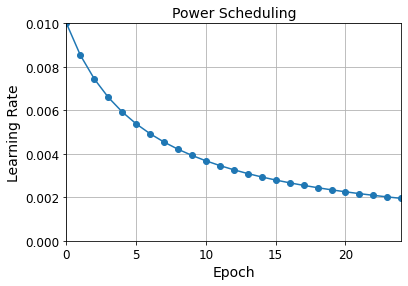

In [76]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size=32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling
#### lr = lr0 * 0.1**(epoch / s)
- The learning rate will gradually drop by a factor of 10 every s steps. 
- While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.
- The LearningRateScheduler will update the optimizer’s learning_rate attribute at the beginning of each epoch.

In [77]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [78]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [79]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs=25

In [80]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 13s 7ms/step - loss: 1.1151 - accuracy: 0.7360 - val_loss: 0.8242 - val_accuracy: 0.7140
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.6714 - accuracy: 0.7964 - val_loss: 0.5488 - val_accuracy: 0.8464
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5694 - accuracy: 0.8229 - val_loss: 0.7165 - val_accuracy: 0.8026
Epoch 4/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5708 - accuracy: 0.8286 - val_loss: 0.5962 - val_accuracy: 0.8322
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4951 - accuracy: 0.8474 - val_loss: 0.5765 - val_accuracy: 0.8458
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4518 - accuracy: 0.8599 - val_loss: 0.4802 - val_accuracy: 0.8562
Epoch 7/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4218 - accuracy: 0.8689 - val_loss: 0.5218 - val_ac

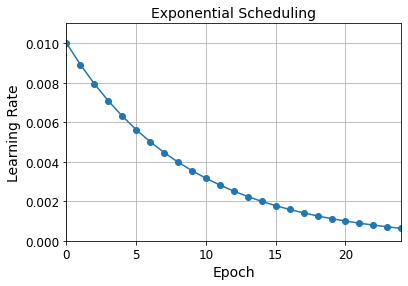

In [81]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [82]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

In [83]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 14s 8ms/step - loss: 1.1227 - accuracy: 0.7344 - val_loss: 0.6928 - val_accuracy: 0.8000
Epoch 2/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.6301 - accuracy: 0.8025 - val_loss: 0.5176 - val_accuracy: 0.8366
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5612 - accuracy: 0.8251 - val_loss: 0.7833 - val_accuracy: 0.8072
Epoch 4/25
1719/1719 [==============================] - 16s 10ms/step - loss: 0.5196 - accuracy: 0.8369 - val_loss: 0.5696 - val_accuracy: 0.8378
Epoch 5/25
1719/1719 [==============================] - 16s 10ms/step - loss: 0.4792 - accuracy: 0.8474 - val_loss: 0.4912 - val_accuracy: 0.8696
Epoch 6/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4182 - accuracy: 0.8662 - val_loss: 0.5097 - val_accuracy: 0.8678
Epoch 7/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3924 - accuracy: 0.8740 - val_loss: 0.5099 - val_

In [84]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

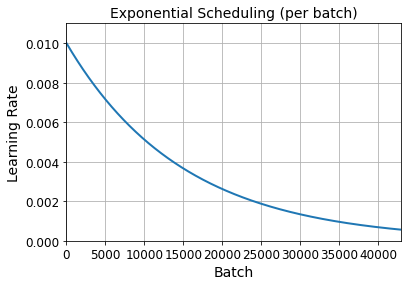

In [85]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling
- Use a constant learning rate for a number of epochs (e.g., lr0=0.1 for 5 epochs), then a smaller learning rate for another number of epochs (e.g., lr1=0.001 for 50 epochs), and so on. 
    - Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.

In [86]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [87]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [88]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 26s 14ms/step - loss: 1.1574 - accuracy: 0.7315 - val_loss: 0.7580 - val_accuracy: 0.7702
Epoch 2/25
1719/1719 [==============================] - 24s 14ms/step - loss: 0.7431 - accuracy: 0.7791 - val_loss: 0.7069 - val_accuracy: 0.7744
Epoch 3/25
1719/1719 [==============================] - 24s 14ms/step - loss: 0.8114 - accuracy: 0.7666 - val_loss: 0.8354 - val_accuracy: 0.7200
Epoch 4/25
1719/1719 [==============================] - 22s 13ms/step - loss: 0.7857 - accuracy: 0.7773 - val_loss: 0.7282 - val_accuracy: 0.77842s - loss: 0.7796 - accura - ETA: 2s - loss: 0.7
Epoch 5/25
1719/1719 [==============================] - 23s 14ms/step - loss: 0.8087 - accuracy: 0.7805 - val_loss: 0.9467 - val_accuracy: 0.6994 - loss: 0.8086 - 
Epoch 6/25
1719/1719 [==============================] - 23s 13ms/step - loss: 0.6022 - accuracy: 0.8109 - val_loss: 0.6328 - val_accuracy: 0.8520
Epoch 7/25
1719/1719 [==============================] - 22

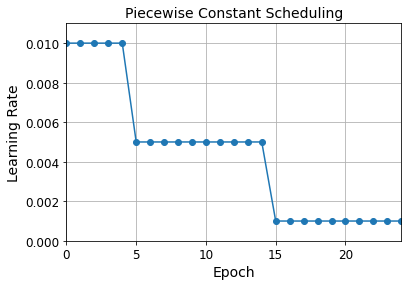

In [89]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling
- Measure the validation error every N steps (just like for early stopping), and reduce the learning rate by a factor of λ when the error stops dropping.
- For performance scheduling, use the ReduceLROnPlateau callback. 
    - For example, if you pass the following callback to the fit() method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for five consecutive epochs.

In [90]:
tf.random.set_seed(42)
np.random.seed(42)

In [91]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid),
                   callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 17s 9ms/step - loss: 0.7110 - accuracy: 0.7761 - val_loss: 0.4654 - val_accuracy: 0.8532
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4818 - accuracy: 0.8410 - val_loss: 0.6064 - val_accuracy: 0.8254
Epoch 3/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5044 - accuracy: 0.8424 - val_loss: 0.5094 - val_accuracy: 0.8472
Epoch 4/25
1719/1719 [==============================] - 19s 11ms/step - loss: 0.4849 - accuracy: 0.8501 - val_loss: 0.4738 - val_accuracy: 0.8618
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5296 - accuracy: 0.8443 - val_loss: 0.5727 - val_accuracy: 0.8300
Epoch 6/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4907 - accuracy: 0.8572 - val_loss: 0.6577 - val_accuracy: 0.8470
Epoch 7/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3442 - accuracy: 0.8861 - val_loss: 0.4124 - val

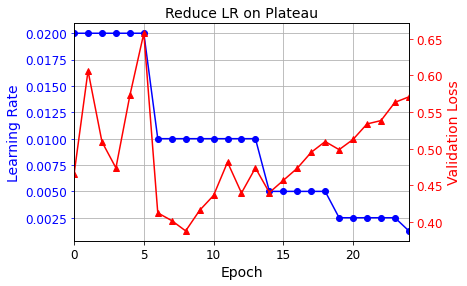

In [92]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers
- Lastly, tf.keras offers an alternative way to implement learning rate scheduling: define the learning rate using one of the schedules available in keras.optimizers.schedules, then pass this learning rate to any optimizer. 
    - This approach updates the learning rate at each step rather than at each epoch.

In [93]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5995 - accuracy: 0.7923 - val_loss: 0.4095 - val_accuracy: 0.8598
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3890 - accuracy: 0.8615 - val_loss: 0.3739 - val_accuracy: 0.8696
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3530 - accuracy: 0.8774 - val_loss: 0.3732 - val_accuracy: 0.8688
Epoch 4/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3296 - accuracy: 0.8819 - val_loss: 0.3494 - val_accuracy: 0.8804
Epoch 5/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3175 - accuracy: 0.8866 - val_loss: 0.3432 - val_accuracy: 0.8796
Epoch 6/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2927 - accuracy: 0.8952 - val_loss: 0.3416 - val_accuracy: 0.8814
Epoch 7/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2851 - accuracy: 0.8990 - val_loss: 0.3355 - val_ac

For piecewise constant scheduling, try this:

In [94]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling
- Contrary to the other approaches, 1cycle (introduced in a 2018 paper by Leslie Smith) starts by increasing the initial learning rate lr0 , growing linearly up to lr1 halfway through training.
    - Then it decreases the learning rate linearly down to lr0 again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly).
    - The maximum learning rate lr1 is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate lr0 is chosen to be roughly 10 times lower.
- When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value.
- Smith did many experiments showing that this approach was often able to speed up training considerably and reach better performance. 
    - For example, on the popular CIFAR10 image dataset, this approach reached 91.9% validation accuracy in just 100 epochs, instead of 90.3% accuracy in 800 epochs through a standard approach (with the same neural network architecture).

- A 2013 paper by Andrew Senior et al. compared the performance of some of the most popular learning schedules when using momentum optimization to train deep neural networks for speech recognition. 
    - The authors concluded that, in this setting, both performance scheduling and exponential scheduling performed well.
    - **They favored exponential scheduling because it was easy to tune and it converged slightly faster to the optimal solution** (they also mentioned that it was easier to implement than performance scheduling, but in Keras both options are easy). 
    - That said, the **1cycle approach seems to perform even better.**

In [95]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [96]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 6s 13ms/step - loss: nan - accuracy: 0.3122


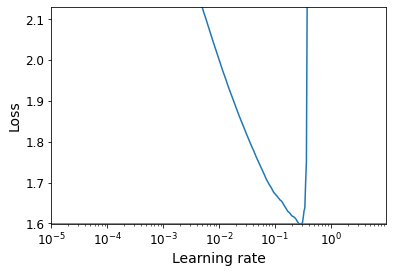

In [97]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [98]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [99]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 6s 14ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8336
Epoch 2/25
430/430 [==============================] - 6s 13ms/step - loss: 0.4581 - accuracy: 0.8396 - val_loss: 0.4275 - val_accuracy: 0.8524
Epoch 3/25
430/430 [==============================] - 5s 13ms/step - loss: 0.4122 - accuracy: 0.8546 - val_loss: 0.4114 - val_accuracy: 0.8578
Epoch 4/25
430/430 [==============================] - 6s 13ms/step - loss: 0.3837 - accuracy: 0.8642 - val_loss: 0.3868 - val_accuracy: 0.8686
Epoch 5/25
430/430 [==============================] - 6s 13ms/step - loss: 0.3639 - accuracy: 0.8718 - val_loss: 0.3767 - val_accuracy: 0.8684
Epoch 6/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3456 - accuracy: 0.8774 - val_loss: 0.3742 - val_accuracy: 0.8708
Epoch 7/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3330 - accuracy: 0.8812 - val_loss: 0.3635 - val_accuracy: 0.8714

## Avoiding Overfitting Through Regularization
- Deep neural networks typically have tens of thousands of parameters, sometimes even millions. 
    - This gives them an incredible amount of freedom and means they can fit a huge variety of complex datasets. 
    - But this great flexibility also makes the network prone to overfitting the training set. We need regularization

## $\ell_1$ and $\ell_2$ regularization
- You can use $\ell_2$ regularization to constrain a neural network’s connection weights, and/or $\ell_1$ regularization if you want a sparse model (with many weights equal to 0).
- Here is how to apply $\ell_2$ regularization to a Keras layer’s connection weights, using a regularization factor of 0.01:

In [100]:
layer = keras.layers.Dense(100, activation="elu", 
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [101]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 22s 11ms/step - loss: 3.2189 - accuracy: 0.7967 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 20s 11ms/step - loss: 0.7280 - accuracy: 0.8247 - val_loss: 0.6850 - val_accuracy: 0.8376


- The l2() function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss.
    - As you might expect, you can just use keras.regularizers.l1() if you want ℓ regularization; if you want both $\ell_1$ and $\ell_2$ regularization, use keras.regularizers.l1_l2() (specifying both regularization factors).
- Since you will typically want to apply the same regularizer to all layers in your network, as well as using the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments.
    - This makes the code ugly and error-prone.
    - To avoid this, you can try refactoring your code to use loops.
    - Another option is to use Python’s **functools.partial()** function, which lets you create a thin wrapper for any callable, with some default argument values:

In [102]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs=2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 21s 10ms/step - loss: 3.2911 - accuracy: 0.7924 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 16s 9ms/step - loss: 0.7282 - accuracy: 0.8245 - val_loss: 0.6826 - val_accuracy: 0.8382


## Dropout
- Dropout is one of the most popular regularization techniques for deep neural networks. It was proposed in a paper by Geoffrey Hinton in 2012 and further detailed in a 2014 paper by Nitish Srivastava et al., and it has proven to be highly successful: even the state-of-the-art neural networks get a 1–2% accuracy boost simply by adding dropout. 
    - This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).
- It is a fairly simple algorithm: **at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability p of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step.**
- The hyperparameter p is called the dropout rate, and it is **typically set between 10% and 50%:** 
    - **closer to 20–30% in recurrent neural nets (RNNs)**, 
    - and **closer to 40–50% in convolutional neural networks (CNNs).**
- After training, neurons don’t get dropped anymore. And that’s all

<img src="11-9.png">

### TIP
In practice, you can usually apply dropout only to the neurons in the top one to three layers (excluding the output layer).
***

- There is one small but important technical detail. Suppose p = 50%, in which case during testing a neuron would be connected to twice as many input neurons as it would be (on average) during training. 
    - To compensate for this fact, we need to multiply each neuron’s input connection weights by 0.5 after training. 
    - If we don’t, each neuron will get a total input signal roughly twice as large as what the network was trained on and will be unlikely to perform well. 
    - More generally, we need to multiply each input connection weight by the **keep probability** (1 – p) after training.
    - Alternatively, we can divide each neuron’s output by the keep probability during training (these alternatives are not perfectly equivalent, but they work equally well).
- To implement dropout using Keras, you can use the **keras.layers.Dropout** layer.
    - During training, it randomly drops some inputs (setting them to 0) and divides the remaining inputs by the keep probability.
    - After training, it does nothing at all; it just passes the inputs to the next layer.

The following code applies dropout regularization before every Dense layer, using a dropout rate of 0.2:

In [103]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 25s 13ms/step - loss: 0.7611 - accuracy: 0.7576 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 23s 13ms/step - loss: 0.4306 - accuracy: 0.8401 - val_loss: 0.3397 - val_accuracy: 0.8720


### WARNING
- Since dropout is only active during training, comparing the training loss and the validation loss can be misleading. 
- In particular, a model may be overfitting the training set and yet have similar training and validation losses. 
    - So make sure to evaluate the training loss without dropout (e.g., after training).
***
- If you observe that **the model is overfitting, you can increase the dropout rate**. 
    - Conversely, you should **try decreasing the dropout rate if the model underfits the training set.**
- It can also help to increase the dropout rate for large layers, and reduce it for small ones. 
- Moreover, many state-of-the-art architectures only use dropout after the last hidden layer, so you may want to try this if full dropout is too strong.
- Dropout does tend to significantly slow down convergence, but it usually results in a much better model when tuned properly. So, it is generally well worth the extra time and effort.


### TIP
- If you want to regularize a self-normalizing network based on the SELU activation function (as discussed earlier), you should use **alpha dropout**: this is a variant of dropout that preserves the mean and standard deviation of its inputs (it was introduced in the same paper as SELU, as regular dropout would break self-normalization).

## Alpha Dropout

In [104]:
tf.random.set_seed(42)
np.random.seed(42)

In [105]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 22s 12ms/step - loss: 0.8023 - accuracy: 0.7146 - val_loss: 0.5778 - val_accuracy: 0.8446
Epoch 2/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.5662 - accuracy: 0.7904 - val_loss: 0.5146 - val_accuracy: 0.8528
Epoch 3/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.5260 - accuracy: 0.8063 - val_loss: 0.4882 - val_accuracy: 0.8612
Epoch 4/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.5124 - accuracy: 0.8098 - val_loss: 0.4795 - val_accuracy: 0.8588
Epoch 5/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5077 - accuracy: 0.8128 - val_loss: 0.4264 - val_accuracy: 0.8704
Epoch 6/20
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4793 - accuracy: 0.8202 - val_loss: 0.4614 - val_accuracy: 0.8624
Epoch 7/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4717 - accuracy: 0.8275 - val_loss: 0.4703 - val

In [106]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4756 - accuracy: 0.8595


[0.4755621552467346, 0.859499990940094]

In [107]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.3529 - accuracy: 0.8823


[0.3528751730918884, 0.8822545409202576]

In [108]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 9s 5ms/step - loss: 0.4231 - accuracy: 0.8421


## Monte Carlo (MC) Dropout
- In 2016, a paper by Yarin Gal and Zoubin Ghahramani added a few more good reasons to use dropout:
    - First, the paper established a profound connection between dropout networks (i.e., neural networks containing a Dropout layer before every weight layer) and approximate Bayesian inference, giving dropout a solid mathematical justification.
    - Second, the authors introduced a powerful technique called MC Dropout, which can boost the performance of any trained dropout model without having to retrain it or even modify it at all, provides a much better measure of the model’s uncertainty, and is also amazingly simple to implement.
- Here is a full implementation of MC Dropout, boosting the dropout model we trained earlier without retraining it:

In [109]:
tf.random.set_seed(42)
np.random.seed(42)

In [110]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

- We just make 100 predictions over the test set, setting **training=True to ensure that the Dropout layer is active, and stack the predictions.** 
- Since dropout is active, all the predictions will be different. 
- Recall that predict() returns a matrix with one row per instance and one column per class.
    - Because there are 10,000 instances in the test set and 10 classes, this is a matrix of shape [10000, 10].
    - We stack 100 such matrices, so y_probas is an array of shape [100, 10000, 10]. Once we average over the first dimension (axis=0), we get y_proba, an array of shape [10000, 10], like we would get with a single prediction.
- That’s all! **Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate** that is generally more reliable than the result of a single prediction with dropout off.

For example, let’s look at the model’s prediction for the first instance in the test set, with dropout off:

In [111]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

The model seems almost certain that this image belongs to class 9 (ankle boot). Should you trust it? Is there really so little room for doubt? Compare this with the predictions made when dropout is activated:

In [112]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.66, 0.  , 0.32]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.87, 0.  , 0.12]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.21, 0.  , 0.78]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.48, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.77, 0.  , 0.23]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.56, 0.  , 0.37]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.24, 0.  , 0.68]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.34, 0.  , 0.06, 0.  , 0.6 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.12, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.25, 0.  , 0.48]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.22, 0.  , 0.77]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.33, 0.  , 0

- This tells a very different story: apparently, when we activate dropout, the model is not sure anymore.

Once we average over the first dimension, we get the following MC Dropout predictions:

In [113]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.24, 0.  , 0.68]],
      dtype=float32)

- The model still thinks this image belongs to class 9, but only with a 68% confidence, which seems much more reasonable than 99%. 
- Plus it’s useful to know exactly which other classes it thinks are likely. 

And you can also take a look at the standard deviation of the probability estimates:

In [114]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.23, 0.  , 0.28]],
      dtype=float32)

- Apparently there’s quite a lot of variance in the probability estimates: if you were building a risk-sensitive system (e.g., a medical or financial system), you should probably treat such an uncertain prediction with extreme caution. 
- You definitely would not treat it like a 99% confident prediction. Moreover, the model’s accuracy got a small boost from 86.8 to 86.9:

In [115]:
y_pred = np.argmax(y_proba, axis=1)

In [116]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8672

### NOTE
- The number of Monte Carlo samples you use (100 in this example) is a hyperparameter you can tweak. 
    - **The higher it is, the more accurate the predictions and their uncertainty estimates will be. However, if you double it, inference time will also be doubled.**
    - Moreover, above a certain number of samples, you will notice little improvement. So your job is to find the right trade-off between latency and accuracy, depending on your application.
***
- **If your model contains other layers that behave in a special way during training (such as BatchNormalization layers)**, then **you should not force training mode** like we just did. 
    - **Instead, you should replace the Dropout layers with the following MCDropout class:**

In [117]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

- If you are creating a model from scratch, it’s just a matter of using MCDropout rather than Dropout.
    - But if you have a model that was already trained using Dropout, you need to create a new model that’s identical to the existing model except that it replaces the Dropout layers with MCDropout, then copy the existing model’s weights to your new model.
- In short, MC Dropout is a fantastic technique that boosts dropout models and provides better uncertainty estimates. And of course, since it is just regular dropout during training, it also acts like a regularizer.

In [118]:
tf.random.set_seed(42)
np.random.seed(42)

In [119]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [120]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [121]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [122]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [123]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.27, 0.  , 0.61]],
      dtype=float32)

## Max-Norm Regularization

In [124]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

- After each training iteration, the model’s fit() method will call the object returned by max_norm(), passing it the layer’s weights and getting rescaled weights in return, which then replace the layer’s weights.
- The max_norm() function has an axis argument that defaults to 0.
    - A Dense layer usually has weights of shape [number of inputs, number of neurons], so using axis=0 means that the max-norm constraint will apply independently to each neuron’s weight vector.
- If you want to use max-norm with convolutional layers, make sure to set the max_norm() constraint’s axis argument appropriately (usually axis=[0, 1, 2]).

In [125]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 7ms/step - loss: 0.5769 - accuracy: 0.8022 - val_loss: 0.3803 - val_accuracy: 0.8596
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3550 - accuracy: 0.8713 - val_loss: 0.3668 - val_accuracy: 0.8698


## Summary
- We have covered a wide range of techniques, and you may be wondering which ones you should use.
- This depends on the task, and there is no clear consensus yet, but I have found the configuration in Table 11-3 to work fine in most cases, without requiring much hyperparameter tuning.
- That said, please do not consider these defaults as hard rules!

<img src="t3.png">

- If the network is a simple stack of dense layers, then it can self-normalize, and you should use the configuration in Table 11-4 instead.

<img src="t4.png">


- Don’t forget to normalize the input features! You should also try to reuse parts of a pretrained neural network if you can find one that solves a similar problem, or use unsupervised pretraining if you have a lot of unlabeled data, or use pretraining on an auxiliary task if you have a lot of labeled data for a similar task.
- While the previous guidelines should cover most cases, here are some exceptions:
    - **If you need a sparse model, you can use ℓ1 regularization (and optionally zero out the tiny weights after training).** 
        - If you need an even sparser model, you can use the TensorFlow Model Optimization Toolkit. 
        - This will break self-normalization, so you should use the default configuration in this case.
    - **If you need a low-latency model (one that performs lightning-fast predictions), you may need to use fewer layers, fold the Batch Normalization layers into the previous layers, and possibly use a faster activation function such as leaky ReLU or just ReLU.**
       - Having a sparse model will also help. Finally, you may want to reduce the float precision from 32 bits to 16 or even 8 bits. Again, check out TF-MOT.
    - **If you are building a risk-sensitive application, or inference latency is not very important** in your application, you can use **MC Dropout to boost performance** and get more reliable probability estimates, along with uncertainty estimates.

## Exercises
##  Deep Learning on CIFAR10
### a.
Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.

In [126]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="elu",
                                 kernel_initializer="he_normal"))

### b.
Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.

Let's add the output layer to the model:

In [127]:
model.add(keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [128]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [129]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170500096/170498071 [==============================] - 100s 1us/step


Now we can create the callbacks we need and train the model:

In [130]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [131]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 9404.

In [132]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 34s 20ms/step - loss: 9.7350 - accuracy: 0.1397 - val_loss: 2.1328 - val_accuracy: 0.2306
Epoch 2/100
1407/1407 [==============================] - 31s 22ms/step - loss: 2.0740 - accuracy: 0.2425 - val_loss: 2.0154 - val_accuracy: 0.2446
Epoch 3/100
1407/1407 [==============================] - 29s 21ms/step - loss: 1.9617 - accuracy: 0.2785 - val_loss: 1.9702 - val_accuracy: 0.2850
Epoch 4/100
1407/1407 [==============================] - 29s 20ms/step - loss: 1.8758 - accuracy: 0.3177 - val_loss: 1.8707 - val_accuracy: 0.3320
Epoch 5/100
1407/1407 [==============================] - 29s 21ms/step - loss: 1.8140 - accuracy: 0.3415 - val_loss: 1.7675 - val_accuracy: 0.3508
Epoch 6/100
1407/1407 [==============================] - 29s 21ms/step - loss: 1.7561 - accuracy: 0.3607 - val_loss: 1.7442 - val_accuracy: 0.3636
Epoch 7/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.7133 - accuracy: 0.3777 - val_loss: 1

In [133]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 6ms/step - loss: 1.5247 - accuracy: 0.4658


[1.52471923828125, 0.4657999873161316]

### c.
Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?

The code below is very similar to the code above, with a few changes:

- I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
- I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
- I renamed the run directories to runbn* and the model file name to my_cifar10_bn_model.h5.

In [134]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 60s 32ms/step - loss: 1.9742 - accuracy: 0.2953 - val_loss: 1.6885 - val_accuracy: 0.3918
Epoch 2/100
1407/1407 [==============================] - 41s 29ms/step - loss: 1.6818 - accuracy: 0.4001 - val_loss: 1.6009 - val_accuracy: 0.4318
Epoch 3/100
1407/1407 [==============================] - 41s 29ms/step - loss: 1.6127 - accuracy: 0.4255 - val_loss: 1.5199 - val_accuracy: 0.4576
Epoch 4/100
1407/1407 [==============================] - 42s 30ms/step - loss: 1.5518 - accuracy: 0.4473 - val_loss: 1.5225 - val_accuracy: 0.4586
Epoch 5/100
1407/1407 [==============================] - 40s 28ms/step - loss: 1.5037 - accuracy: 0.4670 - val_loss: 1.4538 - val_accuracy: 0.4790
Epoch 6/100
1407/1407 [==============================] - 40s 28ms/step - loss: 1.4653 - accuracy: 0.4757 - val_loss: 1.4374 - val_accuracy: 0.4842
Epoch 7/100
1407/1407 [==============================] - 40s 28ms/step - loss: 1.4323 - accuracy: 0.4927 - val_loss: 1

[1.3130398988723755, 0.5429999828338623]

- Is the model converging faster than before? Much faster! The previous model took 27 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 5 epochs and continued to make progress until the 18th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
- Does BN produce a better model? Yes! The final model is also much better, with 54.0% accuracy instead of 47.6%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
- How does BN affect training speed? Although the model converged much faster, each epoch took about 12s instead of 8s, because of the extra computations required by the BN layers. But overall the training time (wall time) was shortened significantly!

### d.
Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

In [135]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 39s 22ms/step - loss: 2.0613 - accuracy: 0.2676 - val_loss: 1.8792 - val_accuracy: 0.3230
Epoch 2/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.7308 - accuracy: 0.3805 - val_loss: 1.7332 - val_accuracy: 0.3790
Epoch 3/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.6281 - accuracy: 0.4276 - val_loss: 1.6625 - val_accuracy: 0.4044
Epoch 4/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.5393 - accuracy: 0.4586 - val_loss: 1.6203 - val_accuracy: 0.4432
Epoch 5/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.4842 - accuracy: 0.4814 - val_loss: 1.5983 - val_accuracy: 0.4248
Epoch 6/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.4447 - accuracy: 0.4944 - val_loss: 1.5023 - val_accuracy: 0.4646
Epoch 7/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.3915 - accuracy: 0.5165 - val_loss: 1

[1.4828822612762451, 0.49880000948905945]

In [136]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 6ms/step - loss: 1.4829 - accuracy: 0.4988


[1.4828822612762451, 0.49880000948905945]

We get 49.8% accuracy, which is not much better than the original model (47.6%), and not as good as the model using batch normalization (54.0%). However, convergence was almost as fast as with the BN model, plus each epoch took only 7 seconds. So it's by far the fastest model to train so far.

### e.
Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.

In [137]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 59s 30ms/step - loss: 2.0557 - accuracy: 0.2807 - val_loss: 1.7831 - val_accuracy: 0.3776
Epoch 2/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.6717 - accuracy: 0.4076 - val_loss: 1.7089 - val_accuracy: 0.3960
Epoch 3/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.5776 - accuracy: 0.4486 - val_loss: 1.6406 - val_accuracy: 0.4324
Epoch 4/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.4946 - accuracy: 0.4766 - val_loss: 1.5477 - val_accuracy: 0.4596
Epoch 5/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.4407 - accuracy: 0.4943 - val_loss: 1.6497 - val_accuracy: 0.4414
Epoch 6/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.3927 - accuracy: 0.5134 - val_loss: 1.5282 - val_accuracy: 0.4762
Epoch 7/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.3452 - accuracy: 0.5303 - val_loss: 1

[1.500890851020813, 0.49540001153945923]

Let's use MC Dropout now. We will need the MCAlphaDropout class we used earlier, so let's just copy it here for convenience:

In [138]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with MCAlphaDropout dropout layers instead of AlphaDropout layers:

In [139]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [140]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [141]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4932

We get no accuracy improvement in this case (we're still at 49% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

In [142]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 11s 26ms/step - loss: nan - accuracy: 0.1252


(9.999999747378752e-06,
 9.615227699279785,
 2.6187450885772705,
 3.9368624346596857)

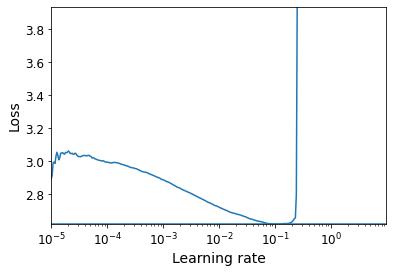

In [143]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [144]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [145]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 11s 27ms/step - loss: 2.2315 - accuracy: 0.2381 - val_loss: 1.8069 - val_accuracy: 0.3794
Epoch 2/15
352/352 [==============================] - 9s 25ms/step - loss: 1.7926 - accuracy: 0.3699 - val_loss: 1.6318 - val_accuracy: 0.4166
Epoch 3/15
352/352 [==============================] - 9s 25ms/step - loss: 1.6395 - accuracy: 0.4185 - val_loss: 1.6519 - val_accuracy: 0.4196
Epoch 4/15
352/352 [==============================] - 9s 25ms/step - loss: 1.5448 - accuracy: 0.4532 - val_loss: 1.6267 - val_accuracy: 0.4330
Epoch 5/15
352/352 [==============================] - 9s 25ms/step - loss: 1.4861 - accuracy: 0.4737 - val_loss: 1.5406 - val_accuracy: 0.4676
Epoch 6/15
352/352 [==============================] - 9s 26ms/step - loss: 1.4361 - accuracy: 0.4894 - val_loss: 1.5364 - val_accuracy: 0.4660
Epoch 7/15
352/352 [==============================] - 9s 25ms/step - loss: 1.4040 - accuracy: 0.4998 - val_loss: 1.6452 - val_accuracy: 0.440

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 47.6% to 52.0%). The batch normalized model reaches a slightly better performance (54%), but it's much slower to train.